# Business Understanding: Define research questions and objectives
#### Research Questions:
##### 1. What is the impact of class attendance on students' overall grades?
##### 2. Are there specific periods with higher absenteeism that correlate with lower grades and are there more absences in certain lessons compared to others?
##### 3. How do different schools compare in terms of student attendance and average grades?
##### 4. What are the predictors of poor academic performance (e.g., average grade below a certain threshold)?


# 2: Data Understanding

In [2]:
import pandas as pd
import joblib
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn import tree
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


# Load the dataset
file_path = 'archive/2023_GradesVsPeriodAttendance_01.csv'
data = pd.read_csv(file_path)

# Display the first few rows and summary of the dataset
data_info = data.info()
data_head = data.head()

print(data_info)
print(data_head)

# Convert letter grades (A, B, C, D, F) into numeric values for analysis.
grade_mapping = {'A': 4, 'B': 3, 'C': 2, 'D': 1, 'F': 0}
for col in ['bellPeriod1_markbook_mark', 'bellPeriod2_markbook_mark', 'bellPeriod3_markbook_mark',
            'bellPeriod4_markbook_mark', 'bellPeriod5_markbook_mark', 'bellPeriod6_markbook_mark']:
    data[col] = data[col].map(grade_mapping)

# Handle missing values for grades by computing average grade
data['average_grade'] = data[['bellPeriod1_markbook_mark', 'bellPeriod2_markbook_mark', 
                              'bellPeriod3_markbook_mark', 'bellPeriod4_markbook_mark', 
                              'bellPeriod5_markbook_mark', 'bellPeriod6_markbook_mark']].mean(axis=1)

# Drop rows where 'average_grade' is missing
data_cleaned = data.dropna(subset=['average_grade'])

# Correlation between attendance and grades
attendance_columns = ['bellPeriod1_absences', 'bellPeriod2_absences', 'bellPeriod3_absences',
                      'bellPeriod4_absences', 'bellPeriod5_absences', 'bellPeriod6_absences', 
                      'total_absences', 'average_grade']
attendance_grade_corr = data_cleaned[attendance_columns].corr()
print("Correlation between attendance and grades:\n", attendance_grade_corr)

# Group by school and calculate average attendance and grades
school_summary = data_cleaned.groupby('school_name')[['total_absences', 'average_grade']].mean()
print("School-wise attendance and grade summary:\n", school_summary)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21305 entries, 0 to 21304
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   school_name                21305 non-null  object
 1   student_id                 21305 non-null  object
 2   grade                      21305 non-null  int64 
 3   term_code                  21305 non-null  object
 4   bellPeriod1_absences       21305 non-null  int64 
 5   bellPeriod2_absences       21305 non-null  int64 
 6   bellPeriod3_absences       21305 non-null  int64 
 7   bellPeriod4_absences       21305 non-null  int64 
 8   bellPeriod5_absences       21305 non-null  int64 
 9   bellPeriod6_absences       21305 non-null  int64 
 10  total_absences             21305 non-null  int64 
 11  bellPeriod1_markbook_mark  20222 non-null  object
 12  bellPeriod2_markbook_mark  20202 non-null  object
 13  bellPeriod3_markbook_mark  20652 non-null  object
 14  bellPe

# 3: Data Preparation

In [3]:
# Aggregate attendance data by period to explore absenteeism patterns
period_absence_avg = data_cleaned[['bellPeriod1_absences', 'bellPeriod2_absences', 'bellPeriod3_absences',
                                   'bellPeriod4_absences', 'bellPeriod5_absences', 'bellPeriod6_absences']].mean()
print("Average absences per period:\n", period_absence_avg)

# Create a binary target variable for poor academic performance (e.g., pass/fail based on grade threshold)
data_cleaned = data_cleaned.copy()
data_cleaned['pass_fail'] = (data_cleaned['average_grade'] >= 2).astype(int)


Average absences per period:
 bellPeriod1_absences    23.463595
bellPeriod2_absences    15.289318
bellPeriod3_absences    14.106022
bellPeriod4_absences    14.438651
bellPeriod5_absences    13.307121
bellPeriod6_absences    13.134113
dtype: float64


# 4: Modelling

In [4]:
# Research Question 1: Impact of attendance on overall grades (Random Forest Regressor)
features = data_cleaned[['bellPeriod1_absences', 'bellPeriod2_absences', 'bellPeriod3_absences',
                         'bellPeriod4_absences', 'bellPeriod5_absences', 'bellPeriod6_absences', 'total_absences']]
target = data_cleaned['average_grade']

# Split dataset for Research Question 1 (Random Forest)
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Train Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Research Question 2: Periods of absenteeism and their effect on grades (Decision Tree Classifier)
decision_tree_model = DecisionTreeClassifier(max_depth=5, random_state=42)

# Use the binary pass/fail target for classification
decision_tree_model.fit(X_train, data_cleaned.loc[X_train.index, 'pass_fail'])

# Research Question 4: Predict poor academic performance (Logistic Regression)
logistic_model = LogisticRegression(random_state=42)
logistic_model.fit(X_train, data_cleaned.loc[X_train.index, 'pass_fail'])


LogisticRegression(random_state=42)

# 5: Model Evaluation
### Question 1: Impact of attendance on grades

Mean Squared Error for attendance vs grades: 0.8396947495171679
R² Score for attendance vs grades: 0.1522989921139104


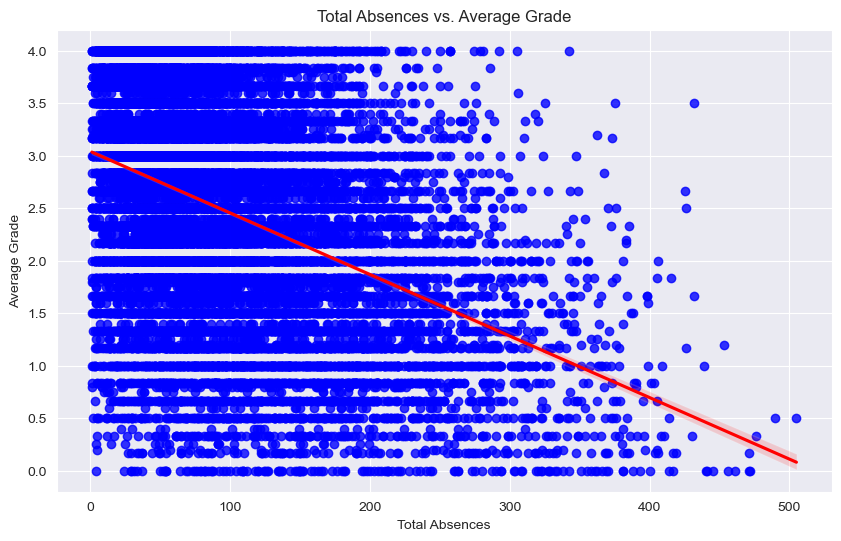

In [5]:
# Predictions for Random Forest Regressor
y_pred_rf = rf_model.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f'Mean Squared Error for attendance vs grades: {mse_rf}')
print(f'R² Score for attendance vs grades: {r2_rf}')

# Scatter plot with regression line
plt.figure(figsize=(10, 6))
sns.regplot(x=data_cleaned['total_absences'], y=data_cleaned['average_grade'], scatter_kws={"color": "blue"}, line_kws={"color": "red"})
plt.title('Total Absences vs. Average Grade')
plt.xlabel('Total Absences')
plt.ylabel('Average Grade')
plt.show()

### Question 2: Impact of specific periods on grades and absences in certain lessons of the day

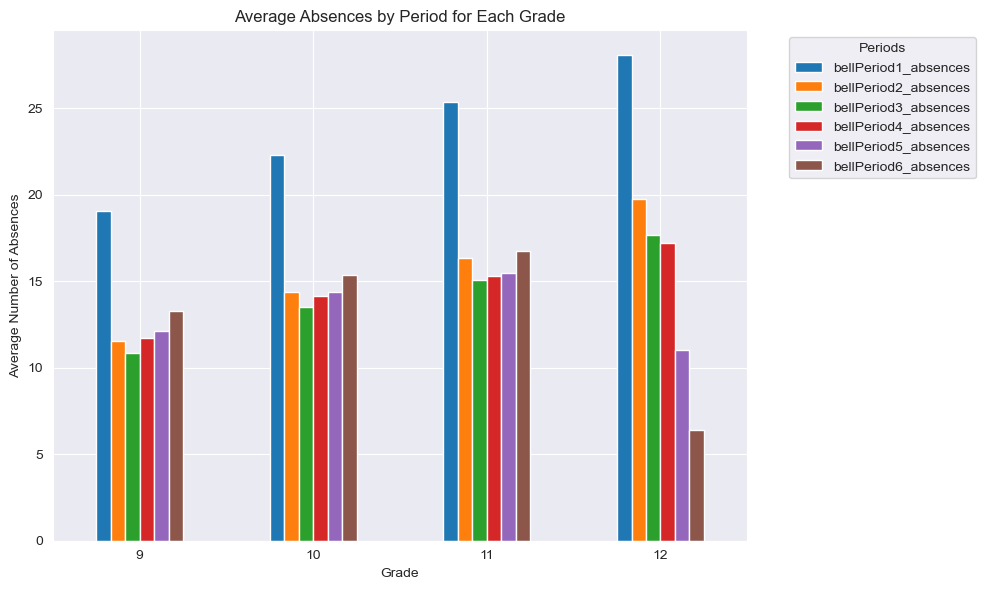

In [6]:
# Calculate average absences for each period, grouped by grade
average_absences_by_grade = data.groupby('grade')[
    ['bellPeriod1_absences', 'bellPeriod2_absences', 'bellPeriod3_absences',
     'bellPeriod4_absences', 'bellPeriod5_absences', 'bellPeriod6_absences']
].mean()

# Display the average absences per period for each grade
average_absences_by_grade

# Set up the plot
average_absences_by_grade.plot(kind='bar', figsize=(10,6))
plt.title('Average Absences by Period for Each Grade')
plt.ylabel('Average Number of Absences')
plt.xlabel('Grade')
plt.xticks(rotation=0)
plt.legend(title='Periods', bbox_to_anchor=(1.05, 1), loc='upper left')

# Display the plot
plt.tight_layout()
plt.show()

##### We observed clear differences in the number of absences across different terms and grade levels. The first lesson is more prone to absences for all grade levels compared to other lessons. As students get older, absences during the first lessons of the morning increase. On the other hand, absences during the sixth lesson decrease, especially among older students, which may indicate possible scheduling changes or increased student engagement in the later lessons of the day.

##### This information could help schools focus their efforts on the first lessons of the morning to reduce absences, particularly in higher grade levels.

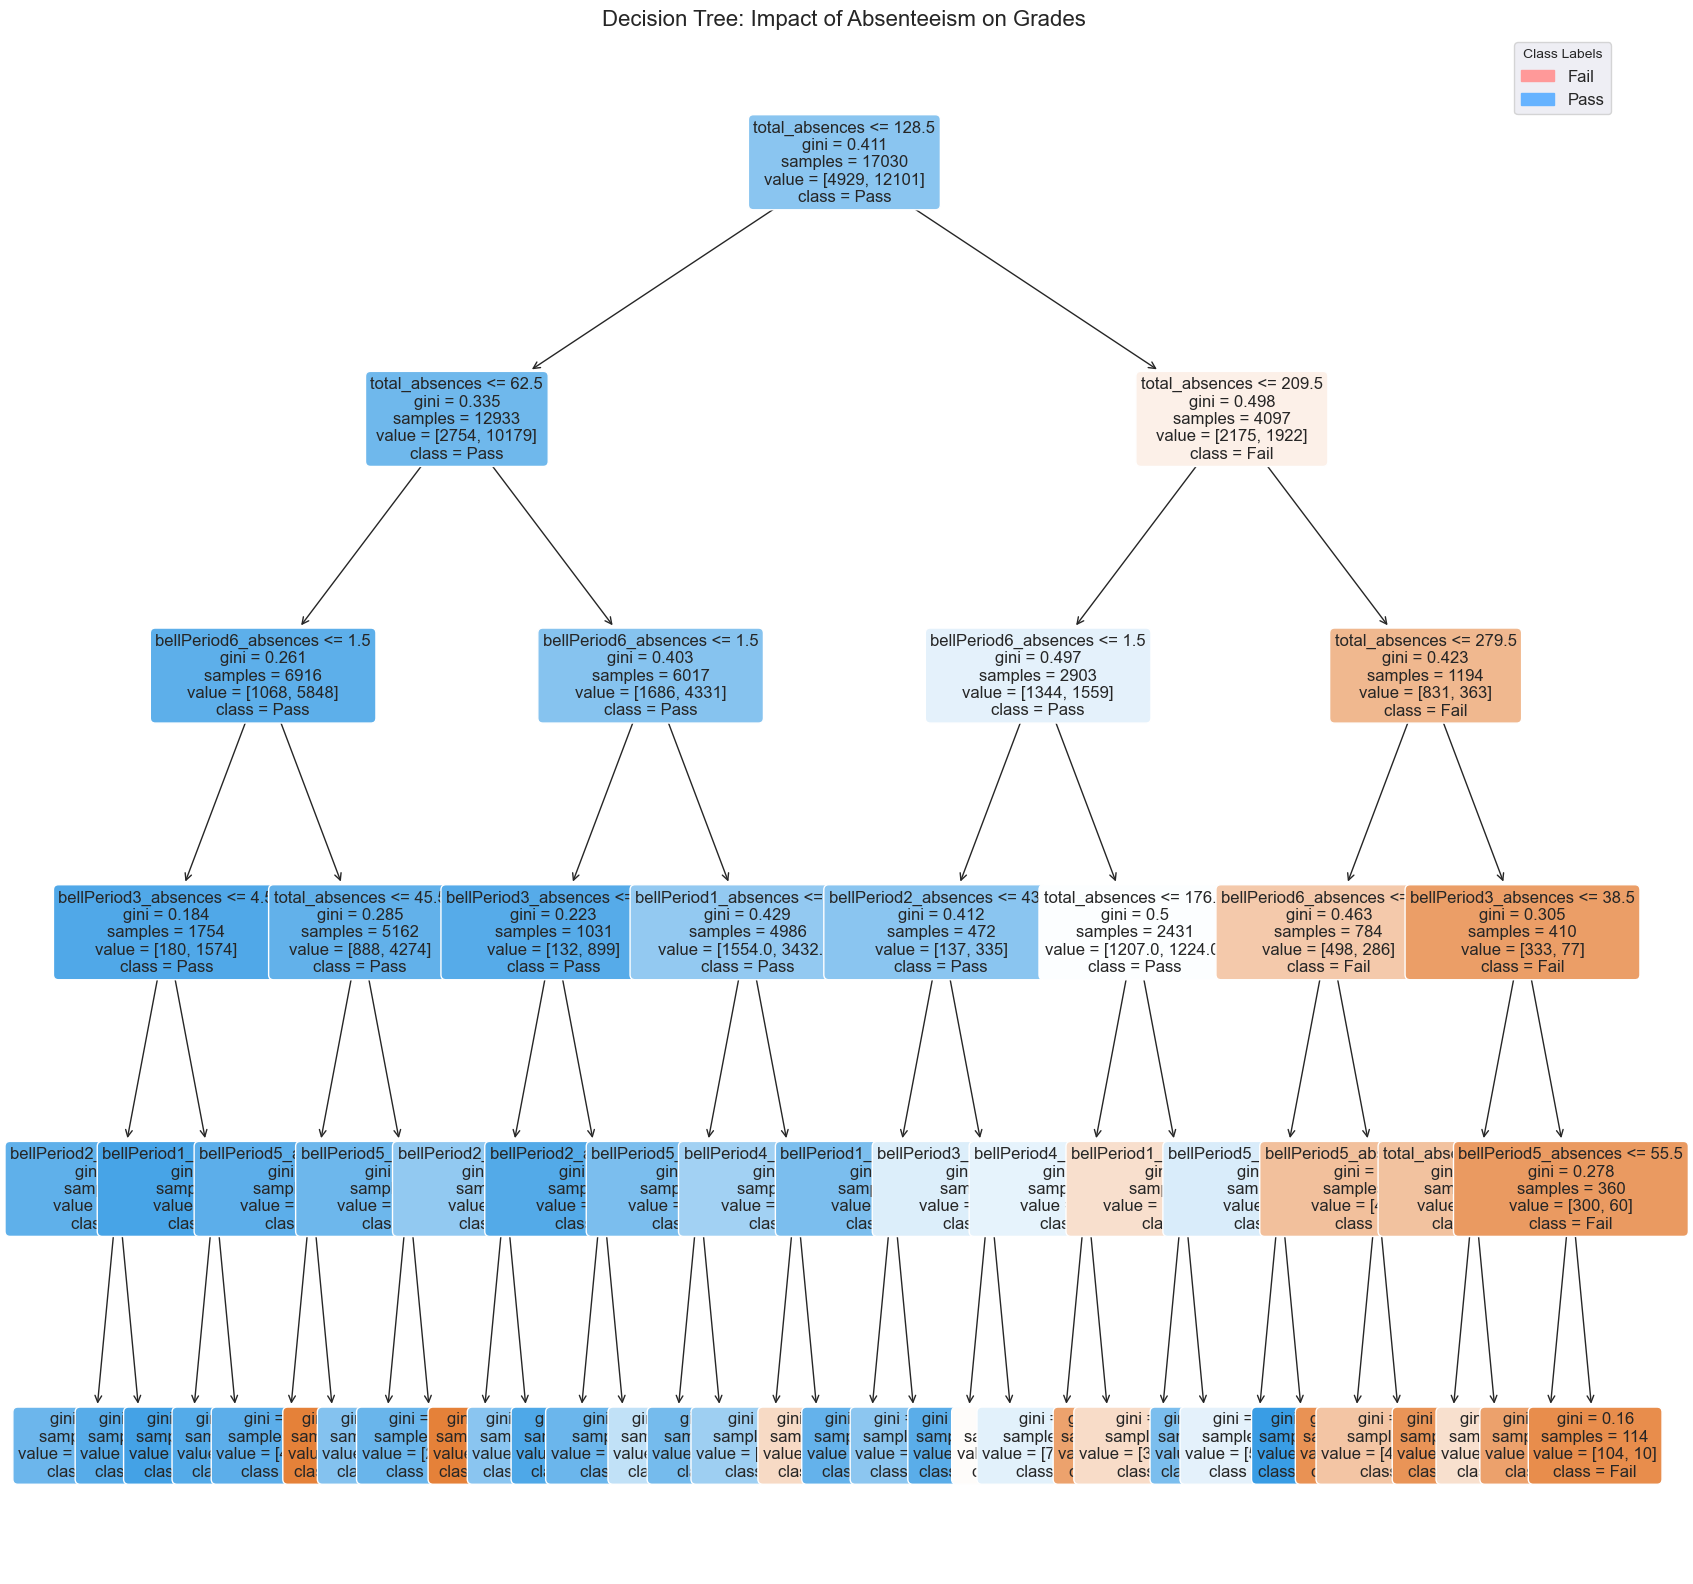

Accuracy for predicting pass/fail with Decision Tree: 0.73


In [7]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score

# Fit your decision tree model (if not already fitted)
# decision_tree_model.fit(X_train, y_train) # Uncomment if needed

# Set the figure size
plt.figure(figsize=(20, 20))

# Plot the decision tree
plot_tree(
    decision_tree_model,
    feature_names=features.columns,
    filled=True,
    class_names=['Fail', 'Pass'],
    rounded=True,
    fontsize=12
)

# Add a title for context
plt.title('Decision Tree: Impact of Absenteeism on Grades', fontsize=16)

# Optionally add a color bar for clarity
# Create a legend for the classes
import matplotlib.patches as mpatches

# Define a legend for the classes
legend_labels = ['Fail', 'Pass']
legend_colors = ['#FF9999', '#66B3FF']  # Corresponding colors for the classes
patches = [mpatches.Patch(color=legend_colors[i], label=legend_labels[i]) for i in range(len(legend_labels))]
plt.legend(handles=patches, title="Class Labels", fontsize=12)

plt.show()

# Evaluate the Decision Tree
y_pred_dt = decision_tree_model.predict(X_test)
accuracy_dt = accuracy_score(data_cleaned.loc[X_test.index, 'pass_fail'], y_pred_dt)
print(f'Accuracy for predicting pass/fail with Decision Tree: {accuracy_dt:.2f}')


##### The main decision point in the tree is whether total absences exceed 128.5 periods. This is the most crucial factor in predicting whether a student will pass or fail.

##### - Students with fewer than 128.5 absences are more likely to pass.
##### - Students with more than 128.5 absences are more likely to fail.

##### Absences during the first period are strongly linked to failure, while absences during the sixth period also help in predicting performance.

##### Color Coding:
##### Blue nodes indicate that the majority of students in that group are predicted to pass.
##### Orange nodes indicate that most are predicted to fail.

##### The Gini score measures how well a node separates students who pass and fail. A lower Gini index indicates a more "pure" node with better separation.

##### samples = 17030 means the dataset includes 17,030 students.
##### value = [4922, 12101] shows that 4,922 students are predicted to fail and 12,101 to pass.

### Question 3: Attendance and grades comparison across schools

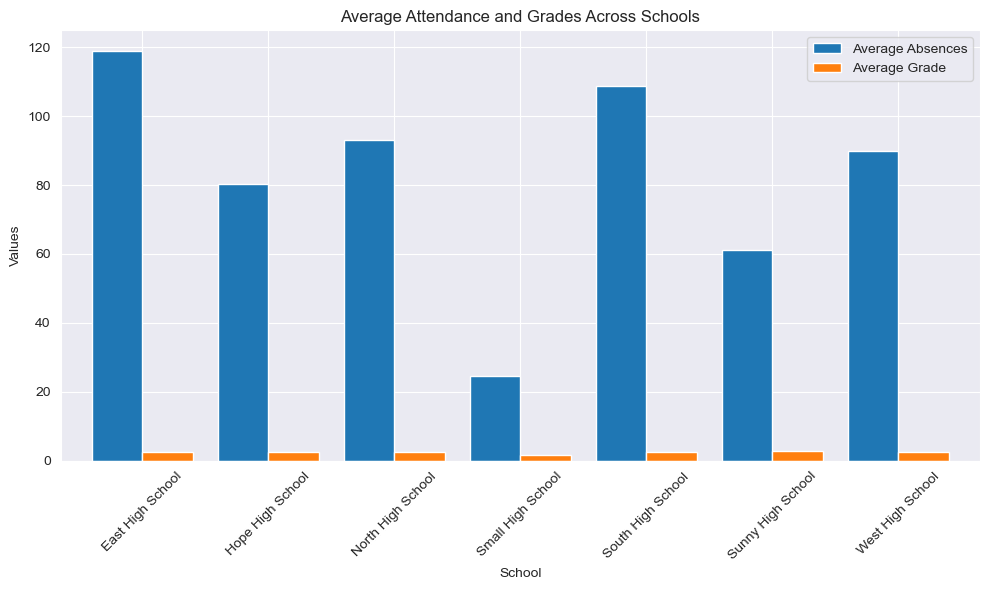

In [8]:
# Grouped bar plot for schools
school_summary.plot(kind='bar', figsize=(10, 6), width=0.8)
plt.title('Average Attendance and Grades Across Schools')
plt.xlabel('School')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.legend(['Average Absences', 'Average Grade'])
plt.tight_layout()
plt.show()

### 4: Predictors of poor academic performance

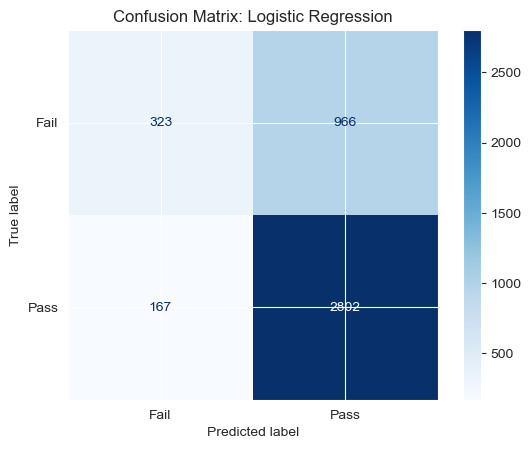

Classification Report:

              precision    recall  f1-score   support

           0       0.66      0.25      0.36      1289
           1       0.74      0.94      0.83      2969

    accuracy                           0.73      4258
   macro avg       0.70      0.60      0.60      4258
weighted avg       0.72      0.73      0.69      4258


In [9]:
# Confusion Matrix
y_pred_logistic = logistic_model.predict(X_test)
cm = confusion_matrix(data_cleaned.loc[X_test.index, 'pass_fail'], y_pred_logistic)

# Display Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fail', 'Pass'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix: Logistic Regression')
plt.show()

# Classification report as a table
print("Classification Report:\n")
print(classification_report(data_cleaned.loc[X_test.index, 'pass_fail'], y_pred_logistic))


# 6: Model Deployment

In [10]:
# Deployment: Save the models for future use
joblib.dump(rf_model, 'attendance_grade_rf_model.pkl')
joblib.dump(logistic_model, 'logistic_performance_model.pkl')

['logistic_performance_model.pkl']